In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

def read_image(file_name) -> np.array:
    """ Reads and image from file

    Args:
        file_name (_type_): _description_

    Returns:
        np.array: _description_
    """
    try:
        with open(file_name, 'r') as file:
                data = file.readlines()

        # Convert the data into a 2D numpy array
        image_data = np.array([list(map(int, line.split())) for line in data])
        
        # Check the shape of the array
        print(f"Image shape: {image_data.shape}")
        return image_data
    
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
        return None

def show_image(image_data): 
    image_data -= 100
    image_data[image_data<0] = 0
    image_data = image_data/2
    plt.imshow(image_data, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()


def generate_combined_noise(width, height):
    def normalize(matrix):
        return (matrix - matrix.min()) / (matrix.max() - matrix.min())

    np.random.seed(42)  
    gaussian_noise = normalize(np.random.normal(loc=0, scale=0.1, size=(height, width)))
    cauchy_noise = normalize(np.random.standard_cauchy(size=(height, width)))
    laplacian_noise = normalize(np.random.laplace(loc=0, scale=1, size=(height, width)))
    normalized_noise = 512* normalize(gaussian_noise+ cauchy_noise+ laplacian_noise)
    return normalized_noise

def generate_perlin_noise(width, height, scale=1000):
    def fade(t):
        return t * t * t * (t * (t * 6 - 15) + 10)

    def lerp(a, b, x):
        return a + x * (b - a)

    def gradient(h, x, y):
        vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
        g = vectors[h % 4]
        return g[0] * x + g[1] * y

    def perlin(x, y):
        X = int(x) & 255
        Y = int(y) & 255
        xf = x - int(x)
        yf = y - int(y)
        u = fade(xf)
        v = fade(yf)

        n00 = gradient(p[X] + p[Y], xf, yf)
        n01 = gradient(p[X] + p[Y + 1], xf, yf - 1)
        n10 = gradient(p[X + 1] + p[Y], xf - 1, yf)
        n11 = gradient(p[X + 1] + p[Y + 1], xf - 1, yf - 1)

        x1 = lerp(n00, n10, u)
        x2 = lerp(n01, n11, u)
        return lerp(x1, x2, v)

    p = np.arange(256)
    np.random.shuffle(p)
    p = np.tile(p, 2)

    noise = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            noise[i][j] = perlin(j / scale, i / scale)

    noise_normalized = (noise - noise.min()) / (noise.max() - noise.min())*512
    return noise_normalized


def generate_deffected_pixels(image = np.zeros([2000,2000]), prob = 0.001, min_ampl = 450, max_ampl = 512):
    total_elements = image.size
    num_to_replace = int(np.ceil(total_elements * prob))
    
    # Generate random indices for replacement
    flat_indices = np.random.choice(total_elements, num_to_replace, replace=False)
    # Generate replacement values (450-512 inclusive)
    replacement_values = np.random.randint(min_ampl, max_ampl+1, num_to_replace)
    
    # Modify the matrix in-place using flat indices
    image.flat[flat_indices] = replacement_values
    
    return image

def save_image_to_file(matrix, filename = 'result.txt'):
    """
    Writes a numpy matrix to a text file with space-separated values and line breaks.
    
    Parameters:
        matrix (np.ndarray): The matrix to be written to file
        filename (str): Name/path of the output text file
    """
    np.savetxt(filename, matrix.astype(int), fmt='%g', delimiter=' ')

def apply_threshold(image, threshold=128):
    # Применяем пороговое значение
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)
    return binary_image


def generate_clouds(width=1000, height=1000, scale=100, threshold=128):
    # Генерация шума Перлина
    perlin_noise = generate_perlin_noise(width, height, scale)
    
    cloud_mask = apply_threshold(perlin_noise, threshold)
    
    mx = np.max(cloud_mask)
    cloud_mask = cloud_mask // mx

    # Преобразование в формат изображения
    return 2-cloud_mask, (cloud_mask)*perlin_noise

def generate_points(image, diam = 2, brightness_factor = 5):

    # Generate 10 random blocks
    num_blocks = 10
    for _ in range(num_blocks):
        # Randomly select the top-left corner of the block
        x = random.randint(0, image.shape[0] - diam)
        y = random.randint(0, image.shape[1] - diam)
        print(x, y)
        
        # Increase the brightness of the block by the specified factor
        image[x:x+diam, y:y+diam] *= brightness_factor
        
        # Ensure values don't exceed the maximum intensity (255 for an 8-bit image)
        image[x:x+diam, y:y+diam] = np.clip(image[x:x+diam, y:y+diam], 0, 512)

    # Display the modified image matrix
    return image

In [72]:
width = 2000
height = 2000

In [74]:
# Пример использования
mask, clouds = generate_clouds(width=width+200, height=height+200, scale=200, threshold=250)
    

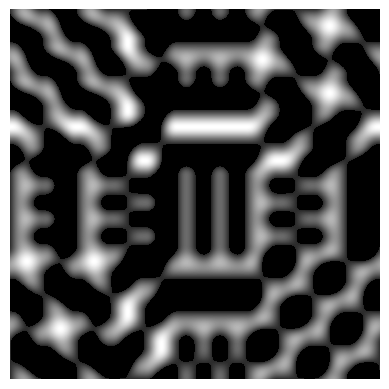

In [75]:
show_image(clouds/np.max(clouds)*255)

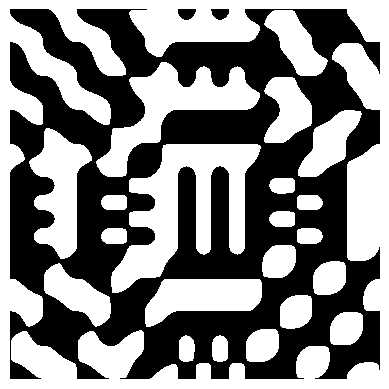

In [79]:
show_image(mask)

In [81]:
(mask-157).max()

1

1531 565
539 1597
801 1524
1229 1181
1109 711
1613 512
995 1961
2026 332
758 942
417 1346


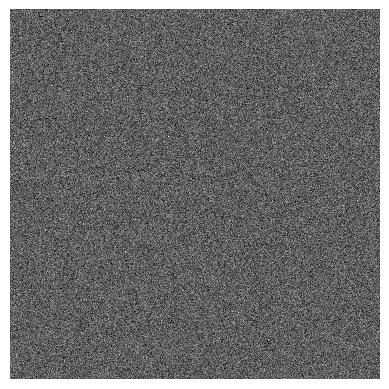

In [83]:
im1 = generate_combined_noise(width+200, height+200)
im1_with_points = generate_points(im1)
show_image(im1_with_points)

In [85]:
im1_with_points.max()
im1_with_points.min()

0.0

In [95]:
from src.image_works import read_image, show_image, generate_combined_noise, generate_perlin_noise, generate_deffected_pixels, save_image_to_file, generate_clouds, generate_points

In [123]:
for i in range(10):
    final_img = (im1_with_points[200-i*10:2200-i*10, 200-i*10:2200-i*10]+100) * (mask[i*10:2000+i*10, i*10:2000+i*10]-157) + clouds[i*10:2000+i*10, i*10:2000+i*10]
    save_image_to_file(final_img, filename = '/Users/N/Documents/GitHub/space-hackathon-2025/Problem_3/Фильм/'+str(i+1)+'.txt')
    print(i)

0
1
2
3
4
5
6
7
8
9


In [87]:
final_img = (im1_with_points+100) * (mask-157) + clouds

In [91]:
final_img.shape

(2200, 2200)

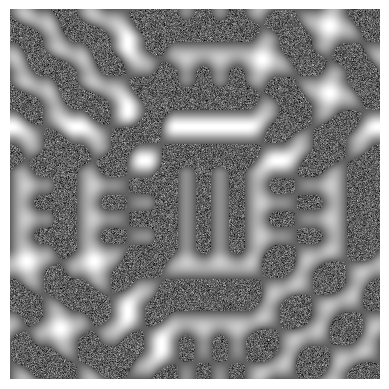

In [89]:
show_image(final_img)

In [ ]:
film_images_orig = []
for i in range(1, 11):
    file_name = 'Фильм/' + str(i) + '.txt'
    im = read_image(file_name)
    film_images_orig.append(im)
    #show_image(im)

In [ ]:
show_image(film_images_orig[0])